The geoIndex class that we explored in the last tutorial is handy for pulling data from large collections of files, but the actual process of reading the data can be very inefficient if there are large numbers of files that contribute data to the same area (as happens near the poles where satellite orbits converge).  To make the reading of the data more efficient, we can rewrite the data into __tiles__ that are spatially organized (in contrast to raw granules, which are usually organized in time.)  The pointCollection has a generic _tile_ class that can do this.

In [1]:
%load_ext autoreload
%autoreload 2;

In [70]:
import pointCollection as pc
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
help(pc.tile)
%autoreload 2



Help on class tile in module pointCollection.tile:

class tile(builtins.object)
 |  tile(xy0=None, bin_W=[10000.0, 10000.0], tile_W=100000.0, SRS_proj4=None, time_field=None, z_field=None)
 |  
 |  A tile is a datafile containing a collection of points from a list of other
 |  files.  It is written as a pointCollectin.indexedH5 file, and contains
 |  a list of the files that contributed to it, as well as a source_file_num
 |  dataset that points to each source file
 |  
 |  Methods defined here:
 |  
 |  __default_field_dict__(self)
 |  
 |  __init__(self, xy0=None, bin_W=[10000.0, 10000.0], tile_W=100000.0, SRS_proj4=None, time_field=None, z_field=None)
 |  
 |  __time_field__(self)
 |  
 |  __z_field__(self)
 |  
 |  from_geoIndex(self, GI_file=None, field_dict=None)
 |  
 |  write(self, out_dir, fields=None, append=True, ind_fields=['x', 'y', 'time'])
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__


This class provides an interface for the lower-level indexedH5 class.  Tiles are usually generated based on an existing geoIndex.  The default process is to identify all the large-scale (typically 100-km) tiles in a geoindex, then for each tile, read all the bins and write the data in each of those bins into a separate file.

In our example (GeoIndex_demo.ipynb), we generated a set of files and indexed them.  Now let's turn these into a set of tiles:

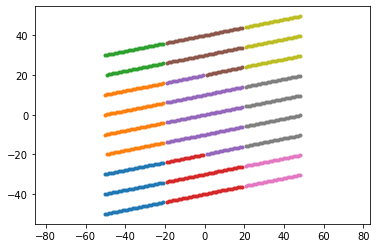

In [71]:
gi_file='../test_data/for_geoindex/GeoIndex.h5'
srs_proj4 = '+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs '


tile_dir='../test_Data/for_geoindex/tiles'
if not os.path.isdir(tile_dir):
    os.mkdir(tile_dir)
else:
    for file in glob.glob(tile_dir+'/*.h5'):
        os.remove(file)
# get the bin locations
bins=pc.geoIndex().from_file(gi_file).bins_as_array()

# get the tile location from the bin locations
tile_size=40.
tile_x=np.unique(np.round(bins[0]/tile_size)*tile_size)
tile_y=np.unique(np.round(bins[1]/tile_size)*tile_size)
# make the tiles:
plt.figure()
for x0 in tile_x:
    for y0 in tile_y:
        xy0=[x0, y0]
        this_tile=pc.tile(tile_W=tile_size, bin_W=[10, 10], SRS_proj4=srs_proj4, xy0=xy0)\
        .from_geoIndex(GI_file=gi_file, field_dict={None:['x','y','z','time']})
        temp=pc.data().from_list(this_tile.D)
        plt.plot(temp.x, temp.y,'.')
        plt.axis('equal')
        this_tile.write(tile_dir, fields=['x','y','time','z'])


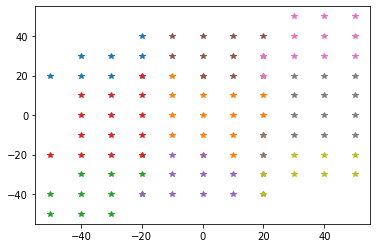

In [37]:
plt.figure()
for file in glob.glob(tile_dir+'/*.h5'):
    bins=pc.geoIndex(delta=[10, 10]).for_file(file, 'indexed_h5').bins_as_array()
    plt.plot(bins[0], bins[1],'*', label=file)


Tiles can also have data appended to them (so that as new data come in, the tiles don't need to be regenerated.)
Let's generate some new data:

In [72]:
test_dir='../test_data/for_geoindex/other_diagonal'

x=np.arange(-50, 50, dtype=np.float64)
y=-0.8*x
t=np.ones_like(x)

if not os.path.isdir(test_dir):
    os.mkdir(test_dir)
for offset in np.arange(-40, 50, 10):
    out_file=test_dir+'/data_%d.h5' % offset
    pc.data().from_dict({'x':x+offset,'y':y, 'z':-(x+offset)**2 - y**2, 'time':t*offset}).to_h5(out_file)
    
test_files=glob.glob(test_dir+'/data*.h5')
index_list = [pc.geoIndex(delta=[10,10]).for_file(file, 'h5') for file in test_files ]
gi=pc.geoIndex(delta=[10, 10], SRS_proj4=srs_proj4).from_list(index_list, dir_root=test_dir+'/')
gi.dir_root=None

gi.to_file(os.getcwd()+'/'+test_dir+'/GeoIndex.h5')

Now let's append it to the existing tiles:

ValueError: Unable to set extend dataset (dimension cannot exceed the existing maximal size (new: 7 max: 6))

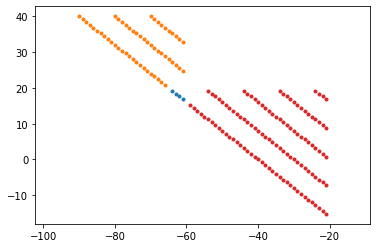

In [73]:
gi_file=os.getcwd()+'/'+test_dir+'/GeoIndex.h5'
bins=pc.geoIndex().from_file(gi_file).bins_as_array()

# get the tile location from the bin locations
tile_size=40.
tile_x=np.unique(np.round(bins[0]/tile_size)*tile_size)
tile_y=np.unique(np.round(bins[1]/tile_size)*tile_size)
# make the tiles:
plt.figure()
for x0 in tile_x:
    for y0 in tile_y:
        xy0=[x0, y0]
        this_tile=pc.tile(tile_W=tile_size, bin_W=[10, 10], SRS_proj4=srs_proj4, xy0=xy0)\
        .from_geoIndex(GI_file=gi_file, field_dict={None:['x','y','z','time']})
        if this_tile.D is None:
            continue
        temp=pc.data().from_list(this_tile.D)
        plt.plot(temp.x, temp.y,'.')
        plt.axis('equal')
        this_tile.write(tile_dir, fields=['x','y','time','z'], append=True)

plt.axis('equal')

In [69]:
gi_file

'/Users/ben/git_repos/pointCollection/test_data/for_geoindex/other_diagonal/GeoIndex.h5'

Now let's see what we have:

test_Data/for_geoindex/tiles/E-40_N40.h5
test_Data/for_geoindex/tiles/E0_N0.h5
test_Data/for_geoindex/tiles/E-40_N-40.h5
test_Data/for_geoindex/tiles/E-80_N0.h5
test_Data/for_geoindex/tiles/E-40_N0.h5
test_Data/for_geoindex/tiles/E0_N-40.h5
test_Data/for_geoindex/tiles/E80_N-40.h5
test_Data/for_geoindex/tiles/E0_N40.h5
test_Data/for_geoindex/tiles/E40_N40.h5
test_Data/for_geoindex/tiles/E40_N0.h5
test_Data/for_geoindex/tiles/E80_N0.h5
test_Data/for_geoindex/tiles/E-80_N40.h5
test_Data/for_geoindex/tiles/E40_N-40.h5


(-98.9, 96.9, -54.980000000000004, 54.58)

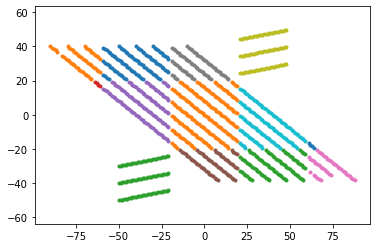

In [65]:
plt.figure()
for file in glob.glob(tile_dir+'/*.h5'):
    print(file)
    bins=pc.geoIndex(delta=[10, 10]).for_file(file, 'indexed_h5').bins_as_array()
    xy=pc.indexedH5.data(filename=file).read(bins, fields=['x','y'])
    plt.plot(xy.x, xy.y,'.')
plt.axis('equal')

NameError: name 'xy' is not defined

In [66]:
gi_file

'/Users/ben/git_repos/pointCollection/test_data/for_geoindex/other_diagonal/GeoIndex.h5'